In [1]:
month = "June"
ROUTE_INPUT = "3A Magenta"


In [2]:
from keras.models import load_model
model = load_model(ROUTE_INPUT+month+'.keras')

2025-01-08 16:05:07.179402: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 16:05:07.181677: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 16:05:07.188049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736332507.198448   27345 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736332507.201496   27345 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 16:05:07.213255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
import numpy as np
import pandas as pd

n_input = 24
# Step 1: Load the saved model
scaler = MinMaxScaler(feature_range=(0, 1))
print(month)
df = read_csv('filtered_pred_'+month+'2024.csv/filtered_'+month+'.csv')

part1_file_path = "part1_dfJune.csv/part1_dfJune.csv"
part1_df = pd.read_csv(part1_file_path)

# Ensure ROUTE_INPUT column exists in part_1.csv
if "ROUTE_NAME" not in part1_df.columns:
    raise ValueError("Column 'ROUTE_INPUT' not found in part_1.csv")

# Get unique ROUTE_INPUT values from part_1.csv
route_input_list = part1_df["ROUTE_NAME"].unique()

# Filter the main DataFrame based on these values
filtered_df = df[df["ROUTE_NAME"].isin(route_input_list)]
# Group by 'DATE_HOUR' and aggregate
df = df.groupby("DATE_HOUR")[["NO_OF_ADULT", "NO_OF_CHILD"]].sum().reset_index()
df['DATE_HOUR'] = pd.to_datetime(df['DATE_HOUR'], format='%Y-%m-%d %H')

# Optionally, you can rename columns if needed
df.rename(columns={"NO_OF_ADULT": "NO_OF_ADULT", "NO_OF_CHILD": "NO_OF_CHILD"}, inplace=True)

df.set_index('DATE_HOUR', inplace=True)
df.sort_index(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)



split_ratio = 0.8
split_index = int(len(scaled_data) * split_ratio)
# Create Train and Test datasets
Train = scaled_data[:split_index]
Test = scaled_data[split_index:]

# Step 14: Generate sequences for the test data
test_generator = TimeseriesGenerator(Test, Test, length=n_input, batch_size=1)

# Step 15: Make predictions
predictions = model.predict(test_generator)

# Step 16: Inverse transform the predictions and actual test data
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(Test[n_input:])  # Use Test[n_input:] for matching lengths


June
 77/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/home/sct/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


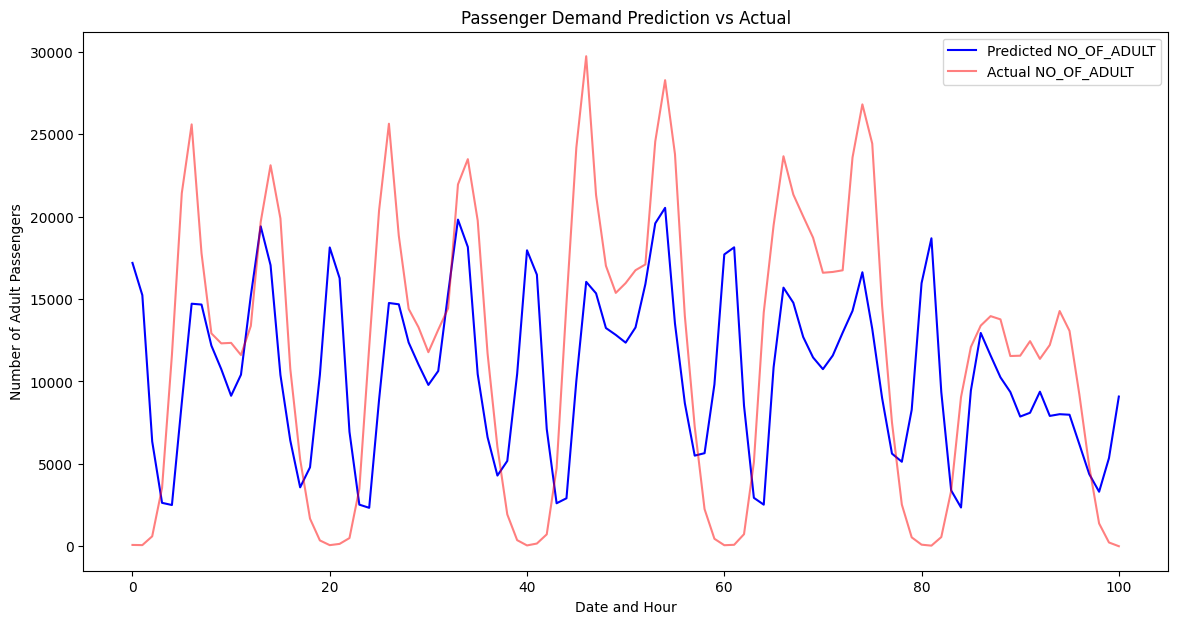

In [10]:
# Step 17: Create a time index for the predicted values
time_index = pd.date_range(start=df.index[split_index + n_input], periods=len(predicted_values), freq='H')

# Step 18: Create a DataFrame for the predicted and actual values for better visualization
results = pd.DataFrame({
    'Predicted_NO_OF_ADULT': predicted_values[:, 0],
    'Predicted_NO_OF_CHILD': predicted_values[:, 1],
    'Actual_NO_OF_ADULT': actual_values[:, 0],
    'Actual_NO_OF_CHILD': actual_values[:, 1],
})

# Step 19: Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Predicted_NO_OF_ADULT'], label='Predicted NO_OF_ADULT', color='blue')
plt.plot(results.index, results['Actual_NO_OF_ADULT'], label='Actual NO_OF_ADULT', color='red', alpha=0.5)
plt.title('Passenger Demand Prediction vs Actual')
plt.xlabel('Date and Hour')
plt.ylabel('Number of Adult Passengers')
plt.legend()
plt.show()

